# Implementation of the SARSA algorithm on the taxi scheduling env

In [2]:
import random
import gym

## <a id="td0"></a>Reminder: Temporal Differences learning

We want to replace Monte-Carlo estimation by a step by step update that only takes $(s,r,s')$ as an input. The key remark we make is that once the $(s,r,s')$ transition is over we can update our knowledge of $V(s)$ by using $r+\gamma V(s')$. This estimate uses $V(s')$ to *bootstrap*[1] the estimator of $V(s)$.


To get an intuitive understanding of why we can do that, take the following example. You are driving from home to the airport. Half-way, you realize traffic is denser than you usually estimate and you're already 5 minutes behind schedule. Home is $s$, half-way is $s'$, those 5 minutes are $r$. To update your belief about the average length of the trip home$\rightarrow$airport ($V(s)$), you don't need to wait until you reach the airport (as a Monte-Carlo estimate would have required). Instead, you can update this belief using $r+V(s')$, the sum of what you observed and what you currently estimate for the rest of the trip. As long as you update all states often enough, the whole procedure should converge to the true $V$.

So here is the update that we shall call TD(0):
<div class="alert-success">**TD(0) temporal difference update:**
$$V(s) \leftarrow V(s) + \alpha \left[ r + \gamma V(s') - V(s) \right]$$
</div>

$\delta=r + \gamma V(s') - V(s)$ is called the prediction **temporal difference** . It is the difference between our estimate $V(s)$ *before* obtaining the information of $r$ and the bootstrapped value $r+\gamma V(s')$.
<div class="alert-success">**Temporal difference:**
$$\delta=r + \gamma V(s') - V(s)$$
</div>

**Bootstrapping** is the operation of using the value of $V(s')$ to update $V(s)$.

This is a sample-by-sample update (no need to remember full episodes) and, more importantly, it is adapted to non-episodic environments (with no terminal states). As for online Monte-Carlo, the update above converges to $V^\pi$ if $\alpha$ respects the Robbins-Monro conditions:
$$\sum\limits_{t=0}^\infty \alpha_t = \infty \quad \textrm{  and  } \quad \sum\limits_{t=0}^\infty \alpha_t^2 < \infty.$$

Often, TD methods converge faster and are more robust estimators than Monte Carlo ones (but not always).

<div class="alert-success">**TD(0) temporal difference update on $Q$-functions:**<br>
In practice, we use TD update on $Q$ functions for the control problem (finding the optimal policy)  
For a sample $(s,a,r,s')$, the temporal difference can take two forms:  

* 1. **SARSA (on-policy algorithm), the focus of this notebook**: $$\delta = r + \gamma Q(s',\pi(s')) - Q(s,a)$$
And the TD update is:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma Q(s'\pi(s')) - Q(s,a) \right]$$

* 2. Q-learning (off-policy algorithm): $$\delta = r + \gamma \max \limits_{a' \in A} Q(s',a') - Q(s,a)$$
And the TD update is:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[r + \gamma \max \limits_{a' \in A} Q(s',a') - Q(s,a) \right]$$

In both cases, as long as all state-action pairs $(s,a)$ are sampled infinitely often as $t\rightarrow\infty$, and under the Robbins-Monro conditions, this procedure converges to $Q^\pi$.
</div>

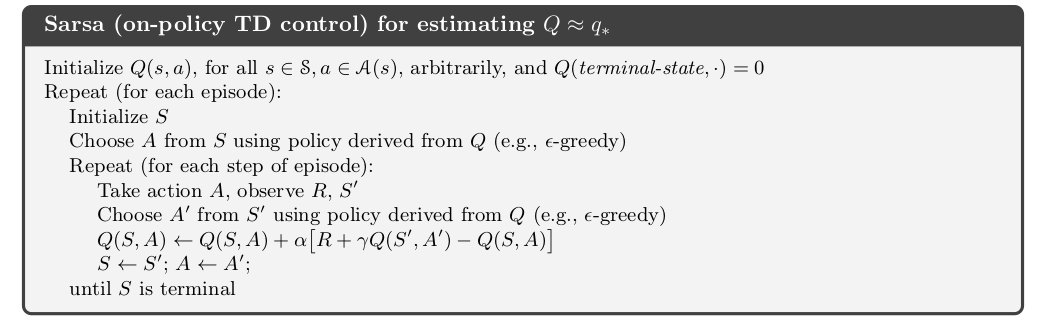

### Looking at the environment

In [3]:
env=gym.make('Taxi-v1')

[2019-08-29 20:22:54,496] Making new env: Taxi-v1


In [4]:
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, B and Y): locations for passengers and destinations

In [11]:
env.observation_space.n

500

In [12]:
env.action_space.n

6

  actions:
    - 0: south
    - 1: north
    - 2: east
    - 3: west
    - 4: pickup
    - 5: dropoff

**rewards**:
* +20 for passenger dropped at the right location
* -10 for drop-off at the wrong location
* -10 for pick-up in a cell with no passenger
* -1 for every other action

**The key to generate episodes is the 'env.step(action)' in openAI gym**

In [9]:
state=env.reset()
for action in range(env.action_space.n):
    next_state, reward, done, _=env.step(action)
    # done is a boolean assessing if the next state is a terminal one

### Parameters of the algorithm

In [23]:
alpha=0.8 # parameter in the TD-update
gamma=0.9 # discount rate

# parameters for building a epsilon-greedy policy with decay
epsilon=0.2
decay_steps=500
decay_rate=0.01

# number of iterations for applying the algorithm
n_iterations=50000 

# to compute the moving average of the reward 
moving_period=100

### Steps to implement the SARSA algorithm

* Initialize the Q value function (= q table), and a cumulative reward equal to 0
* Loop over the iterations
* Generate an episode by initializing the state s
* Take the first action a with a epsilon-greedy policy
* Perform a step in the environment with the 'env.step' function, and store the next state, the reward and the boolean 'done'
* Update the q value for the pair (s,a), by taking an epsilon-greedy policy over the next state: $$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma Q(s'\pi(s')) - Q(s,a) \right]$$
* assign the current state to the next state 
* update the cumulative rewards by adding the reward of the transition
* Check if the next state is a terminal state: if so break the loop over the episodes

### Defining a epsilon-greedy policy
You can code a function with parameters an action and epsilon to build the epsilon-greedy policy used in the algorithm

### Implementing the SARSA algorithm

### Plotting of a moving average of the cumulative rewards